# Inequalities in DIVAnd: Proof of concept

In [1]:
using DIVAnd
using PyPlot
using LinearAlgebra
using SparseArrays

### Classical analysis

 15.337285 seconds (44.37 M allocations: 3.273 GiB, 8.64% gc time, 93.15% compilation time)
extrema(fi) = (-1.3330756974852498, 1.3986669091868735)


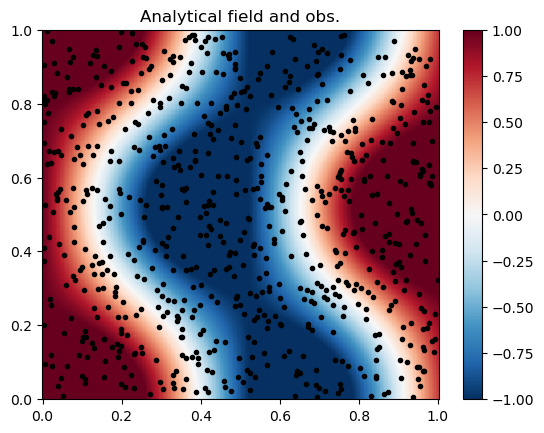

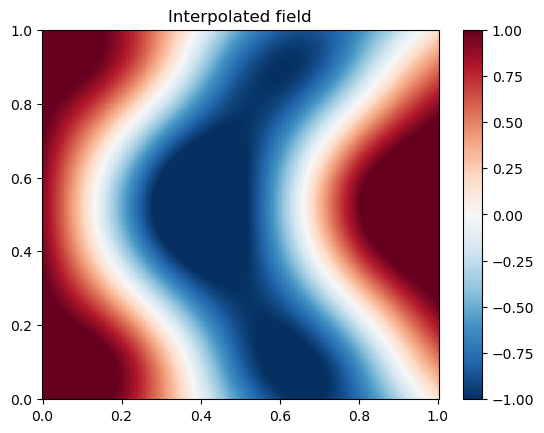

In [2]:
# observations
x = rand(750);
y = rand(750);

testsize=300

f= (sin.(x*6) .* cos.(y*6).+cos.(x*6))

#f = (sin.(x*6) .* cos.(y*6).+ cos.(x*6)) .+ randn(750) ;

# final grid
#


xi,yi= ndgrid(range(0,stop=1,length=testsize),range(0,stop=1,length=testsize));

# reference field
fref = (sin.(xi*6) .* cos.(yi*6).+cos.(xi*6))

# all points are valid points
mask = trues(size(xi));

# this problem has a simple cartesian metric
# pm is the inverse of the resolution along the 1st dimension
# pn is the inverse of the resolution along the 2nd dimension

pm = ones(size(xi)) / (xi[2,1]-xi[1,1]);
pn = ones(size(xi)) / (yi[1,2]-yi[1,1]);


# correlation length
len = 0.4;

# obs. error variance normalized by the background error variance
epsilon2 = 1.;

# fi is the interpolated field
@time fi,s = DIVAndrun(mask,(pm,pn),(xi,yi),(x,y),f,len,epsilon2);
@show extrema(fi)





# plotting of results
figure();
pcolor(xi[:,:],yi[:,:],fref[:,:],cmap="RdBu_r",shading="nearest");
colorbar()
clim(-1,1)
plot(x,y,"k.");
title("Analytical field and obs.");


figure();
pcolor(xi[:,:],yi[:,:],fi[:,:],cmap="RdBu_r",shading="nearest");
colorbar()
clim(-1,1)
title("Interpolated field");
    

 

### Impose positivness

In [3]:
        
        #quick example without any real meaning since imposing a positive solution with a lot of 
        # negativ input values makes not a lot of sense. But anyway, here you go:
        m=sum(mask)
        m2c=DIVAnd.DIVAnd_ineqconstrain(0*ones(Float64,m),Diagonal(ones(Float64,m)))
        fi,s=DIVAndrun(mask,(pm,pn),(xi,yi),(x,y),f,len,epsilon2;ineqconstraints=(m2c,))
        @show extrema(fi)

  
    

    

(sum(Hxo .< yo), norm(Hxo - yo) ^ 2 / (size(yo))[1]) = (47663, 0.6131678876398592)
(violated, ntries) = (47663, 1)
(sum(Hxo .< yo), norm(Hxo - yo) ^ 2 / (size(yo))[1]) = (23858, 0.21758459606204794)
(violated, ntries) = (23858, 2)
(sum(Hxo .< yo), norm(Hxo - yo) ^ 2 / (size(yo))[1]) = (24244, 0.22059041395763626)
(violated, ntries) = (24244, 3)
(sum(Hxo .< yo), norm(Hxo - yo) ^ 2 / (size(yo))[1]) = (17345, 0.22350603229821236)
(violated, ntries) = (17345, 4)
(sum(Hxo .< yo), norm(Hxo - yo) ^ 2 / (size(yo))[1]) = (20353, 0.22633952263183585)
(violated, ntries) = (20353, 5)
(sum(Hxo .< yo), norm(Hxo - yo) ^ 2 / (size(yo))[1]) = (15004, 0.2290837789309836)
(violated, ntries) = (15004, 6)
(sum(Hxo .< yo), norm(Hxo - yo) ^ 2 / (size(yo))[1]) = (14097, 0.23171538807631495)
(violated, ntries) = (14097, 7)
(sum(Hxo .< yo), norm(Hxo - yo) ^ 2 / (size(yo))[1]) = (10984, 0.23428860454123468)
(violated, ntries) = (10984, 8)
(sum(Hxo .< yo), norm(Hxo - yo) ^ 2 / (size(yo))[1]) = (11196, 0.236781407

(-9.484791760007853e-5, 1.3942235941641075)

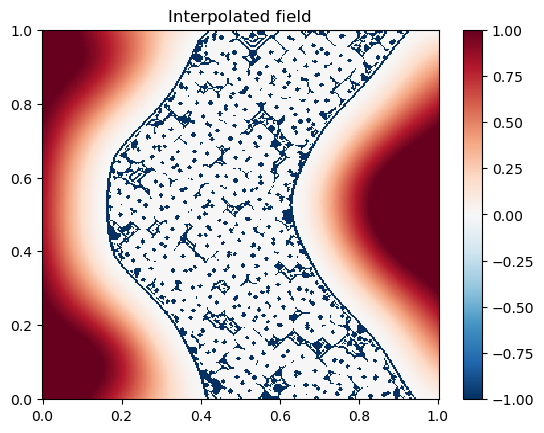

In [4]:
# Show where you still violate the inequality. Unless an analysis without inequality constraint satisfies 
# the inequality constraint, there will always be points where you violate (slightly) the inequality constraint. 
#

fih=deepcopy(fi)
fih[fi.<0.0] .= -1.0

figure()
pcolor(xi[:,:],yi[:,:],fih[:,:],cmap="RdBu_r",shading="nearest");
colorbar()
clim(-1,1)
title("Interpolated field");

### Between two values

(sum(Hxo .< yo), norm(Hxo - yo) ^ 2 / (size(yo))[1]) = (32767, 0.8236014286152836)
(violated, ntries) = (32767, 1)
(sum(Hxo .< yo), norm(Hxo - yo) ^ 2 / (size(yo))[1]) = (27599, 0.9027343466644328)
(violated, ntries) = (27599, 1)
(sum(Hxo .< yo), norm(Hxo - yo) ^ 2 / (size(yo))[1]) = (3413, 0.42511887845767016)
(violated, ntries) = (3413, 2)
(sum(Hxo .< yo), norm(Hxo - yo) ^ 2 / (size(yo))[1]) = (3090, 0.4861347879597385)
(violated, ntries) = (3090, 2)
(sum(Hxo .< yo), norm(Hxo - yo) ^ 2 / (size(yo))[1]) = (6767, 0.4237459046824536)
(violated, ntries) = (6767, 3)
(sum(Hxo .< yo), norm(Hxo - yo) ^ 2 / (size(yo))[1]) = (9615, 0.4849534816231365)
(violated, ntries) = (9615, 3)
(sum(Hxo .< yo), norm(Hxo - yo) ^ 2 / (size(yo))[1]) = (5630, 0.42238040844224434)
(violated, ntries) = (5630, 4)
(sum(Hxo .< yo), norm(Hxo - yo) ^ 2 / (size(yo))[1]) = (4848, 0.4837594995676767)
(violated, ntries) = (4848, 4)
(sum(Hxo .< yo), norm(Hxo - yo) ^ 2 / (size(yo))[1]) = (7395, 0.42103395638756297)
(violat

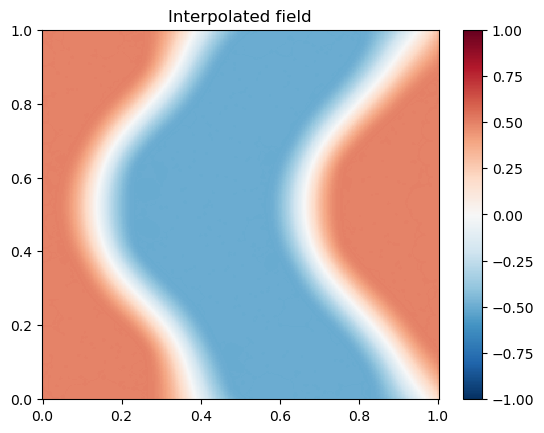

In [5]:
        m=sum(mask)
        m2ca=DIVAnd.DIVAnd_ineqconstrain(-0.5*ones(Float64,m),Diagonal(ones(Float64,m)))
        m2cb=DIVAnd.DIVAnd_ineqconstrain(-0.5*ones(Float64,m),-Diagonal(ones(Float64,m)))
        fi,s=DIVAndrun(mask,(pm,pn),(xi,yi),(x,y),f,len,epsilon2;ineqconstraints=(m2ca,m2cb))
        @show extrema(fi)
        figure()
        pcolor(xi[:,:],yi[:,:],fi[:,:],cmap="RdBu_r",shading="nearest");
        colorbar()
        clim(-1,1)
        title("Interpolated field");

### If you want to try the next cell with variations:

* `for i = 1:1` Impose increasing values in x direction
* `for i = 2:2` Impose increasing values in y direction
* `for i = 1:2` Impose increasing value in oblique direction 


(increase values in both directions is also possible by making two constraints)

(sum(Hxo .< yo), norm(Hxo - yo) ^ 2 / (size(yo))[1]) = (48949, 30.078234624126285)
(violated, ntries) = (48949, 1)
(sum(Hxo .< yo), norm(Hxo - yo) ^ 2 / (size(yo))[1]) = (37709, 8.892682134877639)
(violated, ntries) = (37709, 2)
(sum(Hxo .< yo), norm(Hxo - yo) ^ 2 / (size(yo))[1]) = (37297, 9.971539676988755)
(violated, ntries) = (37297, 3)
(sum(Hxo .< yo), norm(Hxo - yo) ^ 2 / (size(yo))[1]) = (38017, 10.582457908045136)
(violated, ntries) = (38017, 4)
(sum(Hxo .< yo), norm(Hxo - yo) ^ 2 / (size(yo))[1]) = (36165, 10.984664001687593)
(violated, ntries) = (36165, 5)
(sum(Hxo .< yo), norm(Hxo - yo) ^ 2 / (size(yo))[1]) = (37674, 10.956964797697584)
(violated, ntries) = (37674, 6)
(sum(Hxo .< yo), norm(Hxo - yo) ^ 2 / (size(yo))[1]) = (37350, 11.028089280328645)
(violated, ntries) = (37350, 7)
(sum(Hxo .< yo), norm(Hxo - yo) ^ 2 / (size(yo))[1]) = (37106, 11.052175641860709)
(violated, ntries) = (37106, 8)
(sum(Hxo .< yo), norm(Hxo - yo) ^ 2 / (size(yo))[1]) = (37131, 11.068366172486156)

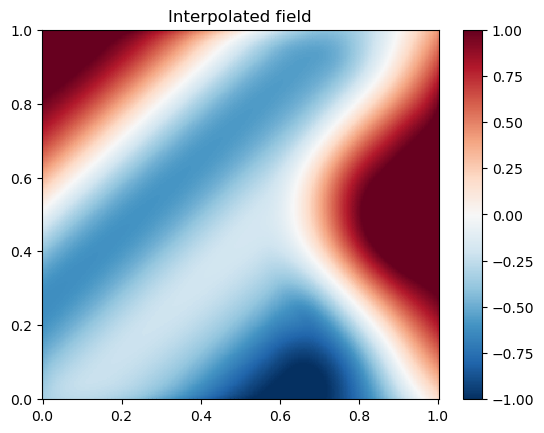

In [17]:
# Other try: increasing in a given direction with gradient of at least 0.1

# Creation of gradient operator matrix in direction i
A = spzeros(s.sv.n, s.sv.n)

for i = 1:2
        S = sparse_stagger(size(mask), i, s.iscyclic[i])
        m = (S * mask[:]) .== 1
        A = A +  sparse_pack(mask) * S' * sparse_pack(m)' * s.Dx[i]
end



        yo=statevector_pack(s.sv, (0.0 .*fi.+0.1,))
        
        
        m2c=DIVAnd.DIVAnd_ineqconstrain(yo, A)
        
        fi,s=DIVAndrun(mask,(pm,pn),(xi,yi),(x,y),f,len,epsilon2;ineqconstraints=(m2c,),ntriesmax=20)
        
        figure()
            pcolor(xi[:,:],yi[:,:],fi[:,:],cmap="RdBu_r",shading="nearest");
            colorbar()
            clim(-1,1)
            title("Interpolated field");

    

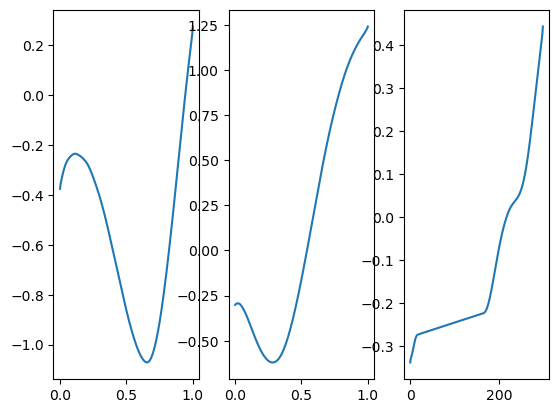

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x00000205EAE5AEB0>

In [18]:
subplot(1,3,1)
plot(xi[:,10],fi[:,10])
subplot(1,3,2)

plot(yi[10,:],fi[10,:])
subplot(1,3,3)
fd=[fi[i,i] for i = 1:size(fi)[1]]
plot(fd)



## Other possible inequalities

* Increasing value along trajectories (if closed trajectoy should lead to constant value along closed line)
* Average over certain region larger than a value
* Stable stratification (do we keep the interface for multivariate variables as in `DIVAnd_multivarEOF` ? What about defining which direction is vertical ? Paramater `vertical=` )
* Limitations on gradients (upper and lower values)


## To be aware of


* Be sure to think about the background field effect when defining the constraints. More general question on how to deal with background fields ? Separate creation and tools (user defined or adapted functions) to merge background and anomalies analysis ?

In [19]:
?DIVAndrun

search: DIVAndrun DIVAndrunfi DIVAnd_residual DIVAnd_residualobs



```
DIVAndrun(mask,pmn,xi,x,f,len,epsilon2; <keyword arguments>)
```

Perform an n-dimensional variational analysis of the observations `f` located at the coordinates `x`. The array `fi` represent the interpolated field at the grid defined by the coordinates `xi` and the scales factors `pmn`.

# Input:

  * `mask`: binary mask delimiting the domain. true is inside and false outside.

For oceanographic application, this is the land-sea mask where sea is true and land is false.

  * `pmn`: scale factor of the grid. pmn is a tuple with n elements. Every  element represents the scale factor of the corresponding dimension. Its  inverse is the local resolution of the grid in a particular dimension.  For example, in two dimensions, `pmn` is a tuple `(pm,pn)` where `pm` is  the inverse of the local resolution in first dimension and `pn` is the the inverse  of the local resolution in second dimension.
  * `xi`: tuple with n elements. Every element represents a coordinate of the final grid on which the observations are interpolated.
  * `x`: tuple with n elements. Every element represents a coordinate of the observations.
  * `f`: value of the observations *minus* the background estimate (vector of `m` elements where `m` is the number of observations). See also note.
  * `len`: tuple with n elements. Every element represents the correlation length for a given dimension.
  * `epsilon2`: error variance of the observations (normalized by the error variance of the background field). `epsilon2` can be a scalar (all observations have the same error variance and their errors are decorrelated), a vector (all observations can have a different error variance and their errors are decorrelated) or a matrix (all observations can have a different error variance and their errors can be correlated). If `epsilon2` is a scalar, it is thus the *inverse of the signal-to-noise ratio*.

# Optional input arguments specified as keyword arguments

  * `velocity`: velocity of the advection constraint. It is a tuple of n arrays and each array represents a single velocity component. The individual array should have the same size as the final grid. The first (second,..) element of the velocity is the velocity compomenent along the first (second,...) dimension. The `velocity` has the units of a length-scale. If this parameter is derived from ocean currents, then the later must be multiplied by a factor (to be determined for example by cross-validation) and this factor has the units of a time-scale. The default is no-advection constraint.
  * `alpha`: alpha is vector of coefficients multiplying various terms in the      cost function. The first element multiplies the norm.      The other i-th element of alpha multiplies the (i+1)-th derivative.      Per default, the highest derivative is m = ceil(1+neff/2) where neff is the      effective dimension of the problem (the number of dimensions with a nonzero      correlation length) and `ceil` is the ceiling function (rounding up).

```
   The values of alpha is the (m+1)th row of the Pascal triangle:
      m=0         1
      m=1       1   1
      m=1     1   2   1     (n=1,2)
      m=2   1   3   3   1   (n=3,4)
      ...
```

  * `constraints`: a structure with user specified quandratic constraints (see `DIVAnd_addc`).
  * `ineqconstraints`: a structure with user specified inequality constraints such that the analysis `x` satisfies`Hx >= y0`. There is no check if the inequality constraints make sense are compatible with each other or with the data. Inequalities will not be satisfied exactly everywhere unless they are already satisfied with a normal analysis. You can increase the number of iterations by increasing `ntriesmax`.
  * `moddim`: modulo for cyclic dimension (vector with n elements).    Zero is used for non-cyclic dimensions. One should not include a boundary    zone (sometimes called a ghost zone or halo) for cyclic dimensions.    For example if the first dimension    is cyclic, then the grid point corresponding to `mask[1,j]` should be    between `mask[end,j]` (left neighbor) and `mask[2,j]` (right neighbor).
  * `fracindex`: fractional indices (n-by-m array). If this array is specified,    then x and xi are not used.
  * `inversion`: direct solver (`:chol` for Cholesky factorization), an    interative solver (`:pcg` for preconditioned conjugate gradient [1]) can be    used or `:cg_amg_sa` for a multigrid method with preconditioned conjugate     gradient. The two last methods are iterative methods who a controlled by     the number of iterations `maxit` and the tolerance `tol`.
  * `compPC`: function that returns a preconditioner for the primal formulation    if inversion is set to `:pcg`. The function has the following arguments:

    ```
         fun = compPC(iB,H,R)
    ```

    where iB is the inverse background error covariance, H the observation   operator and R the error covariance of the observation. The function `compPC` returns the   preconditioner `fun(x,fx)` computing fx = `M \ x` (the inverse of M times x)   where `M` is a positive defined symmetric matrix [1].   Effectively, the system E⁻¹ A (E⁻¹)ᵀ (E x) = E⁻¹ b is solved for (E x) where E Eᵀ = M.   Ideally, M should this be similar to A, so that E⁻¹ A (E⁻¹)ᵀ is close to the identity matrix.
  * `fi0`: starting field for iterative primal algorithm (same size as `mask`).
  * `f0`: starting field for iterative dual algorithm (same size as the observations `f`).
  * `operatortype`: Val{:sparse} for using sparse matrices (default) or Val{:MatFun} or using functions   to define the constrains.
  * `scale_len`: true (default) if the correlation length-scale should be scaled   such that the analytical   kernel reaches 0.6019072301972346 (besselk(1.,1.)) at the same distance   than in 2D. The kernel behaves thus similar to   the default kernel in two dimensions (alpha = [1,2,1]).
  * `alphabc`: numerical value defining how the last grid points are stretched outward.  If `alphabc` is 1, the default value mimics an infinite domain.  To have previous behaviour of finite domain use alphabc equal to `0`.
  * `btrunc`: if provided defines where to truncate the calculation of the   covariance matrix B. Only values up and including alpha[btrunc] will be   calculated. If the iterative solution is calculated, the missing terms will   be calculated on the fly during the conjugate gradient calculations.    Default value is none and full covariance calculation.

# Output:

  * `fi`: the analysed field
  * `s`: a structure with an array `s.P` representing the analysed error covariance

# Note:

If zero is not a valid first guess for your variable (as it is the case for   e.g. ocean temperature), you have to subtract the first guess from the   observations before calling DIVAnd and then add the first guess back in.

# Example:

see `DIVAnd_simple_example.jl`

# References

[1]  [The preconditioned conjugate gradient method](https://en.wikipedia.org/w/index.php?title=Conjugate_gradient_method&oldid=761287292#The_preconditioned_conjugate_gradient_method)
